In [ ]:
import os 

In [ ]:
train_path = '/media/space/ssd_1_tb_evo_sumsung/MishaHW/train_embeddings.tsv'
test_path = '/media/space/ssd_1_tb_evo_sumsung/MishaHW/test_embeddings.tsv'

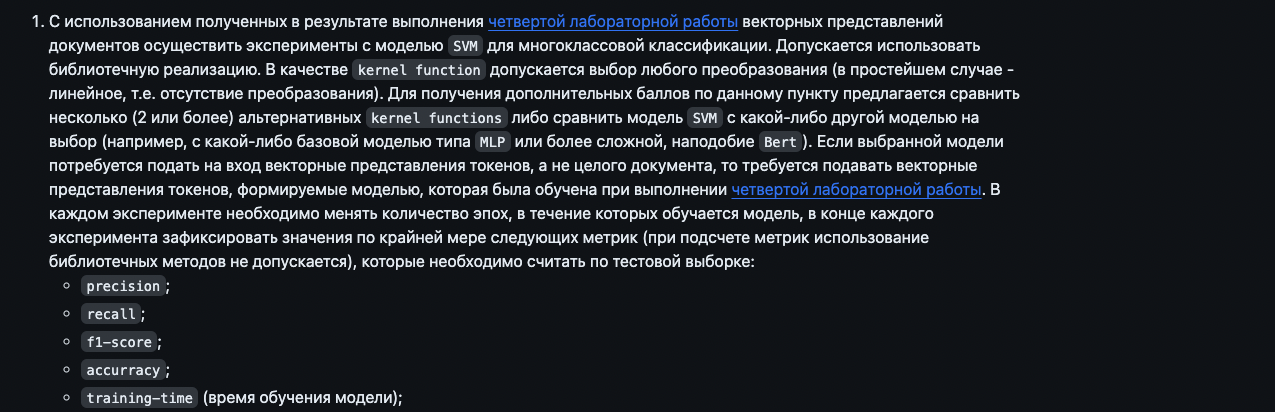

### 1.1 Загрузка векторных представлений и разбиение на выборки

In [ ]:
path_foldes = '/media/space/ssd_1_tb_evo_sumsung/MishaHW/20news-bydate-train'

labels = os.listdir(path_foldes)
for catalog in labels:
    include_catalog = os.listdir(os.path.join(path_foldes, catalog))
    for file in include_catalog:
        if os.path.isdir(os.path.join(path_foldes, f'{catalog}/{file}')):
            labels.append(f'{catalog}/{file}')

In [ ]:
def dataloader(filepath):
    x = list()
    y = list()
    with open(filepath) as f:
        lines = f.readlines()
        for line in lines:
            split_data = line.split()
            class_label = split_data[0].split('/')[0]
            x_data = list(map(float, split_data[1:]))
            
            x.append(x_data)
            y.append(class_label)
    return x, y

In [ ]:
X_train, y_train = dataloader(train_path)
X_test, y_test = dataloader(test_path)

In [ ]:
len(set(y_train))

In [ ]:
encode = {}
count = 0 
for label in set(y_train):
    encode[label] = count
    count += 1

In [ ]:
Y_train = []
for label in y_train:
    if label in encode.keys():
            Y_train.append(encode[label])
y_train = Y_train

In [ ]:
Y_test = []
for label in y_test:
    if label in encode.keys():
            Y_test.append(encode[label])
y_test = Y_test

### 1.2 Создаем несколько моделей SVM и ещё MLP (доп. баллы из-за нескольких моделей)

Linear Kernel (линейное ядро):
Линейное ядро просто выполняет линейное преобразование данных в более высокоразмерное пространство, где классы могут быть линейно разделены.
Это подходит для задач, в которых классы можно разделить прямой линией или гиперплоскостью в исходном пространстве признаков.


Polynomial Kernel (полиномиальное ядро):
Полиномиальное ядро преобразует данные в пространство более высокой степени с использованием полиномиальной функции.
Вам нужно указать степень полинома, которая определяет, какой степени будет полиномиальное преобразование. Например, "degree=2" означает квадратичное преобразование.
Это ядро подходит для задач, где данные имеют нелинейные зависимости между признаками.


RBF Kernel (радиально-базисное функциональное ядро):
RBF-ядро (или гауссово ядро) преобразует данные в пространство с бесконечным числом измерений, используя гауссово распределение.
Это ядро особенно полезно, когда классы нелинейно разделимы и имеют сложные формы.
RBF-ядро имеет два гиперпараметра: gamma (γ) и C. Параметр gamma контролирует форму ядра, а параметр C регулирует сложность модели и баланс между подгонкой (переобучением) и обобщением.

In [ ]:
import numpy as np
from tqdm import tqdm

In [ ]:
from sklearn import svm
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x


In [ ]:
def fit_MLP(model, X, y, epochs):

    start_time = time.time()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    x_train_tensor = torch.Tensor(X)
    y_train_tensor = torch.LongTensor(y)

    dataset = TensorDataset(x_train_tensor, y_train_tensor)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}')
    return model, time.time() - start_time

def eval_MLP(model, X):
    answer = list()
    for item in tqdm(X, desc = "Evaluation"):
        model.eval()
        with torch.no_grad():
            y_pred = model(torch.Tensor(item))
            answer.append(torch.argmax(y_pred).item())
    return answer


In [ ]:
model = svm.SVC(kernel='linear')

model_poly = svm.SVC(kernel='poly', degree=3)

model_rbf = svm.SVC(kernel='rbf')

linear

In [ ]:
start_time = time.time()
model.fit(X_train, y_train)
training_time = time.time() - start_time

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from collections import defaultdict
import numpy as np

def metrics_multiclass(true_labels, predicted_labels):
    true_positive = defaultdict(int)
    false_positive = defaultdict(int)
    false_negative = defaultdict(int)
    true_negative = defaultdict(int)

    unique_classes = set(true_labels) | set(predicted_labels)
    for cls in unique_classes:
        for t, p in zip(true_labels, predicted_labels):
            if t == cls and p == cls:
                true_positive[cls] += 1
            elif t == cls and p != cls:
                false_negative[cls] += 1
            elif t != cls and p == cls:
                false_positive[cls] += 1
            elif t != cls and p != cls:
                true_negative[cls] += 1

    precision = {}
    recall = {}
    f1_score = {}
    correct_predictions = 0

    for cls in unique_classes:
        precision[cls] = (true_positive[cls] / (true_positive[cls] + false_positive[cls])) if (true_positive[cls] + false_positive[cls]) > 0 else 0
        recall[cls] = (true_positive[cls] / (true_positive[cls] + false_negative[cls])) if (true_positive[cls] + false_negative[cls]) > 0 else 0
        f1_score[cls] = (2 * precision[cls] * recall[cls] / (precision[cls] + recall[cls])) if (precision[cls] + recall[cls]) > 0 else 0
        correct_predictions += true_positive[cls]

    avg_precision = np.mean(list(precision.values()))
    avg_recall = np.mean(list(recall.values()))
    avg_f1_score = np.mean(list(f1_score.values()))
    total_accuracy = correct_predictions / len(true_labels)

    return avg_precision, avg_recall, avg_f1_score, total_accuracy

In [ ]:
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

poly


In [ ]:
start_time = time.time()
model_poly.fit(X_train, y_train)
training_time = time.time() - start_time

In [ ]:
y_pred = model_poly.predict(X_test)

In [ ]:
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

rbf

In [ ]:
start_time = time.time()
model_rbf.fit(X_train, y_train)
training_time = time.time() - start_time

In [ ]:
y_pred = model_rbf.predict(X_test)

In [ ]:
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

mlp

In [ ]:
input_size = np.array(X_train).shape[1]
output_size = len(set(y_train))

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, X_train, y_train, 60)

In [ ]:
y_pred = eval_MLP(mlp, X_test)

In [ ]:
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

# 2

Выбор ядра в методах машинного обучения, таких как SVM (Support Vector Machines), сильно влияет на производительность модели, особенно когда речь идет о сложных наборах данных с высокой размерностью. В вашем случае, когда модель с радиально-базисной функцией (RBF) ядра показывает лучшие результаты по сравнению с линейным и полиномиальным ядрами для 100-мерных векторов, причины могут быть следующими:

Сложность данных: RBF-ядра хорошо справляются с наборами данных, где отношения между классами нелинейны и сложны. В высокомерных пространствах, как в вашем случае с 100-мерными векторами, линейные модели могут не улавливать всю сложность данных, в то время как RBF может более эффективно учитывать нелинейные отношения.

Разделение пространства признаков: RBF-ядро преобразует пространство признаков таким образом, что данные, которые не были линейно разделимы в исходном пространстве, могут стать разделимыми в новом пространстве. Это особенно важно в высокомерных пространствах.

Гиперпараметры: Модели с RBF-ядром имеют дополнительные гиперпараметры, такие как параметр γ (гамма), который определяет степень влияния отдельного обучающего примера. Настройка этих гиперпараметров может привести к значительному улучшению производительности модели.

Регуляризация: В случае полиномиального ядра, степень полинома является критическим параметром, который может привести к переобучению, особенно в высокомерных пространствах. RBF-ядро часто более устойчиво к переобучению за счет своих свойств регуляризации.

Проблема измерений: В высокомерных пространствах, таких как 100-мерные векторы, линейные и полиномиальные ядра могут страдать от "проклятия размерности", где добавление измерений увеличивает пространство таким образом, что требуется экспоненциально больше данных для поддержания того же уровня производительности. RBF может лучше справляться с этой проблемой.



# 3

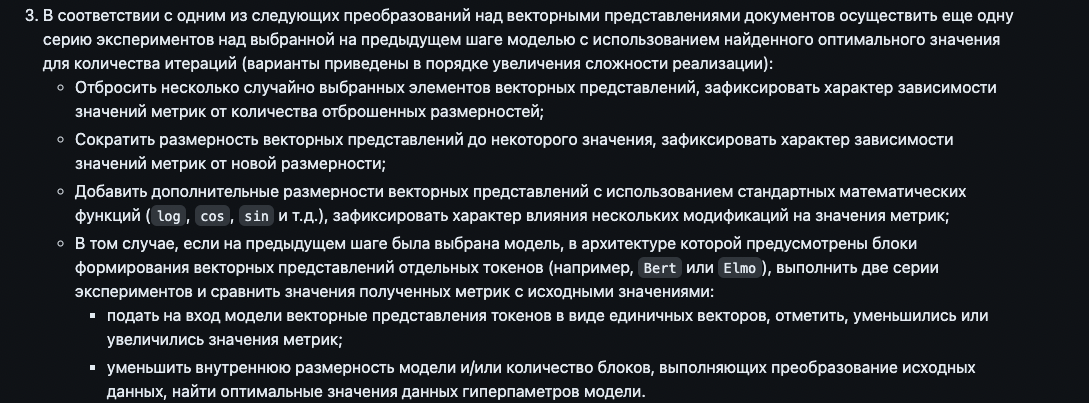

In [ ]:
len(X_train)

# 3.1

In [ ]:
kernel = ['Linear', 'Poly', 'RBF']
for i, m in enumerate([model, model_poly, model_rbf]):
    start_time = time.time()
    m.fit(X_train[:8000], y_train[:8000])
    training_time = time.time() - start_time
    y_pred = m.predict(X_test)
    avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
    print(f"Model kernel: {kernel[i]}")
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1 Score:", avg_f1)
    print("Total Accuracy:", accuracy)
    print(f"Training-time: {training_time} sec")
    print("")

input_size = np.array(X_train[:8000]).shape[1]
output_size = 20

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, X_train[:8000], y_train[:8000], 60)

y_pred = eval_MLP(mlp, X_test)
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print()
print("Model: MLP")
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

In [ ]:
kernel = ['Linear', 'Poly', 'RBF']
for i, m in enumerate([model, model_poly, model_rbf]):
    start_time = time.time()
    m.fit(X_train[:4000], y_train[:4000])
    training_time = time.time() - start_time
    y_pred = m.predict(X_test)
    avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
    print(f"Model kernel: {kernel[i]}")
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1 Score:", avg_f1)
    print("Total Accuracy:", accuracy)
    print(f"Training-time: {training_time} sec")
    print("")

input_size = np.array(X_train[:4000]).shape[1]
output_size = 20

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, X_train[:4000], y_train[:4000], 60)

y_pred = eval_MLP(mlp, X_test)
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print()
print("Model: MLP")
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

# 3.2

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=60)
pca.fit(X_train)

In [ ]:
kernel = ['Linear', 'Poly', 'RBF']
for i, m in enumerate([model, model_poly, model_rbf]):
    start_time = time.time()
    m.fit(pca.transform(X_train), y_train)
    training_time = time.time() - start_time
    y_pred = m.predict(pca.transform(X_test))
    avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
    print(f"Model kernel: {kernel[i]}")
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1 Score:", avg_f1)
    print("Total Accuracy:", accuracy)
    print(f"Training-time: {training_time} sec")
    print("")

input_size = np.array(pca.transform(X_train)).shape[1]
output_size = 20

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, pca.transform(X_train), y_train, 60)

y_pred = eval_MLP(mlp, pca.transform(X_test))
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print()
print("Model: MLP")
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

In [ ]:
pca = PCA(n_components=80)
pca.fit(X_train)

In [ ]:
kernel = ['Linear', 'Poly', 'RBF']
for i, m in enumerate([model, model_poly, model_rbf]):
    start_time = time.time()
    m.fit(pca.transform(X_train), y_train)
    training_time = time.time() - start_time
    y_pred = m.predict(pca.transform(X_test))
    avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
    print(f"Model kernel: {kernel[i]}")
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1 Score:", avg_f1)
    print("Total Accuracy:", accuracy)
    print(f"Training-time: {training_time} sec")
    print("")

input_size = np.array(pca.transform(X_train)).shape[1]
output_size = 20

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, pca.transform(X_train), y_train, 60)

y_pred = eval_MLP(mlp, pca.transform(X_test))
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print()
print("Model: MLP")
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")

In [ ]:
np.array(X_train).shape

In [ ]:
x_train_ext = np.concatenate((X_train, np.sin(X_train), np.cos(X_train)), axis=1)
x_test_ext = np.concatenate((X_test, np.sin(X_test), np.cos(X_test)), axis=1)

In [ ]:
kernel = ['Linear', 'Poly', 'RBF']
for i, m in enumerate([model, model_poly, model_rbf]):
    start_time = time.time()
    m.fit(x_train_ext, y_train)
    training_time = time.time() - start_time
    y_pred = m.predict(x_test_ext)
    avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
    print(f"Model kernel: {kernel[i]}")
    print("Precision:", avg_precision)
    print("Recall:", avg_recall)
    print("F1 Score:", avg_f1)
    print("Total Accuracy:", accuracy)
    print(f"Training-time: {training_time} sec")
    print("")

input_size = np.array(x_train_ext).shape[1]
output_size = 20

hidden_size1 = 50
hidden_size2 = 40

num_epochs = 100

model_mlp = MLPModel(input_size, hidden_size1, hidden_size2, output_size)
mlp, training_time = fit_MLP(model_mlp, x_train_ext, y_train, 60)

y_pred = eval_MLP(mlp, x_test_ext)
avg_precision, avg_recall, avg_f1, accuracy = metrics_multiclass(y_test, y_pred)
print()
print("Model: MLP")
print("Precision:", avg_precision)
print("Recall:", avg_recall)
print("F1 Score:", avg_f1)
print("Total Accuracy:", accuracy)
print(f"Training-time: {training_time} sec")